In [6]:
library(tidyverse)

kyoto_df <- data.frame(data.table::fread("../outputs/A_outputs/A31_japan_temperature.csv"))
head(kyoto_df)
dim(kyoto_df)

station_ids <- unique(kyoto_df$id)
length(station_ids)

,id,date,tmax,tmin,prcp,year,month,day,row_num,id_rownum
,<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>
1,JA000047632,1951-01-01,4.3,0.7,2.1,1951,1,1,1,JA000047632-1
2,JA000047632,1951-01-02,6.7,-0.9,0.0,1951,1,2,2,JA000047632-2
3,JA000047632,1951-01-03,7.4,-2.4,0.0,1951,1,3,3,JA000047632-3
4,JA000047632,1951-01-04,7.9,0.6,0.0,1951,1,4,4,JA000047632-4
5,JA000047632,1951-01-05,8.4,1.7,0.0,1951,1,5,5,JA000047632-5
6,JA000047632,1951-01-06,6.4,-0.4,0.0,1951,1,6,6,JA000047632-6


[1] 380757     10

[1] 15

In [7]:
# Chill-day model (Cesaraccio et al., 2004)
# - Consists of 6 cases: (Tc: threshold temp, Tn = daily minimum, Tx = daily maximum, Tm = daily mean, Cd = chill days, Ca = anti-chill days)

chill_days <- function(r, Tc = 7) {
    
    Tmin <- as.numeric(r[["tmin"]])
    Tmax <- as.numeric(r[["tmax"]])
    Tmean <- (Tmin + Tmax)/2

    if (0 <= Tc & Tc <= Tmin & Tmin <= Tmax) {
        
        Cd <- 0
        Ca <- Tmean - Tc

    } else if (0 <= Tmin & Tmin <= Tc & Tc <= Tmax) {

        Cd <- -1 * ((Tmean - Tmin) - ((Tmax - Tc)/2))
        Ca <- (Tmax - Tc)/2

    } else if (0 <= Tmin & Tmin <= Tmax & Tmax <= Tc) {

        Cd <- -1 * (Tmean - Tmin)
        Ca <- 0
    
    } else if (Tmin <= 0 & 0 <= Tmax & Tmax <= Tc) {

        Cd <- -1 * (Tmax / (Tmax - Tmin)) * (Tmax/2)
        Ca <- 0

    } else if (Tmin <= 0 & 0 <= Tc & Tc <= Tmax) {

        Cd <- -1 * ((Tmax / (Tmax - Tmin)) * (Tmax/2) - ((Tmax - Tc)/2))
        Ca <- (Tmax - Tc) / 2

    } else if (Tmax < 0) {

        Cd <- 0
        Ca <- 0

    } else {
        
        Cd <- 0
        Ca <- 0
    }

    return(c(Cd, Ca))
}

In [8]:
japan_list <- list()

for (st in station_ids) {
    
    temp_df <- kyoto_df[kyoto_df$id == st, ]
    temp_df$daily_Cd <- apply(temp_df, MARGIN = 1, FUN = function(x) {chill_days(r = x)[1]})
    temp_df$daily_Ca <- apply(temp_df, MARGIN = 1, FUN = function(x) {chill_days(r = x)[2]})
    japan_list[[st]] <- temp_df
}

japan_df1 <- japan_list %>% bind_rows()
head(japan_df1)
dim(japan_df1)

,id,date,tmax,tmin,prcp,year,month,day,row_num,id_rownum,daily_Cd,daily_Ca
,<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
1,JA000047632,1951-01-01,4.3,0.7,2.1,1951,1,1,1,JA000047632-1,-1.800000,0.00
2,JA000047632,1951-01-02,6.7,-0.9,0.0,1951,1,2,2,JA000047632-2,-2.953289,0.00
3,JA000047632,1951-01-03,7.4,-2.4,0.0,1951,1,3,3,JA000047632-3,-2.593878,0.20
4,JA000047632,1951-01-04,7.9,0.6,0.0,1951,1,4,4,JA000047632-4,-3.200000,0.45
5,JA000047632,1951-01-05,8.4,1.7,0.0,1951,1,5,5,JA000047632-5,-2.650000,0.70
6,JA000047632,1951-01-06,6.4,-0.4,0.0,1951,1,6,6,JA000047632-6,-3.011765,0.00


[1] 380757     12

In [7]:
## For example, for year 1960,
# yr <- 2001
# kyoto_sub <- kyoto_df[kyoto_df$year %in% c(yr-1, yr), ] %>% arrange(date)
# # tail(kyoto_sub)
# cherry_sub <- read.csv("/home/joosungm/projects/def-lelliott/joosungm/projects/peak-bloom-prediction/A_outputs/A11_cherry_sub.csv") %>%
#     filter(city == "Kyoto")

# actual_date <- cherry_sub[cherry_sub$year == yr, "bloom_date"]
# # head(cherry_sub)

# test_df <- kyoto_sub[kyoto_sub$date > as.Date(paste0(as.character(yr-1), "-09-30")), ]
# test_df$Cd_cumsum <- cumsum(test_df$daily_Cd)

# Rc <- -110 # 저온요구도
# Rh <- 210  # 고온요구도
# Rc_loc <- which(test_df$Cd_cumsum < Rc)[1]
# # test_df
# # Rc_loc <- which(test_df$date == paste0(as.character(yr), "-01-31"))
# print(paste0("reaches the Rc threshold on ", test_df[Rc_loc, "date"])) # 저온요구도 달성일 i.e., 내생휴면 해제일

# test_df_afterRc <- test_df[Rc_loc:nrow(test_df), ]
# # head(test_df_afterRc)
# test_df_afterRc$Ca_cumsum <- cumsum(test_df_afterRc$daily_Ca)
# # head(test_df_afterRc)
# Rc_loc2 <- which(test_df_afterRc$Ca_cumsum > -Rc)[1]
# print(paste0("reaches the Rc threshold for buds on ", test_df_afterRc[Rc_loc2, "date"]))

# Rh_loc <- which(test_df_afterRc$Ca_cumsum > Rh)[1]
# print(paste0("Actual date: ", actual_date, " vs. ", "predicted cherry blossom date: ", test_df_afterRc[Rh_loc, "date"]))

[1] "reaches the Rc threshold on 2001-01-08"
[1] "reaches the Rc threshold for buds on 2001-03-19"
[1] "Actual date: 2001-04-03 vs. predicted cherry blossom date: 2001-04-07"


In [4]:
dim(japan_df1)
head(japan_df1)
unique(japan_df1$month)

[1] 319668     12

,id,date,tmax,tmin,prcp,year,month,day,row_num,id_rownum,daily_Cd,daily_Ca
,<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
1,JA000047636,1951-01-01,6.6,-0.4,0.2,1951,1,1,1,JA000047636-1,-3.111429,0.00
2,JA000047636,1951-01-02,6.3,-2.5,0.0,1951,1,2,2,JA000047636-2,-2.255114,0.00
3,JA000047636,1951-01-03,7.8,-4.2,0.0,1951,1,3,3,JA000047636-3,-2.135000,0.40
4,JA000047636,1951-01-04,8.7,0.6,0.0,1951,1,4,4,JA000047636-4,-3.200000,0.85
5,JA000047636,1951-01-05,8.6,0.4,0.0,1951,1,5,5,JA000047636-5,-3.300000,0.80
6,JA000047636,1951-01-06,6.6,-0.1,0.0,1951,1,6,6,JA000047636-6,-3.250746,0.00


[1]  1  2  3  4  5  6  7  8  9 10 11 12

In [11]:
# Obtain cumsum of Cd and Ca
# - Cd: start from (yr-1)-10-01
# - Ca: start from yr-01-31
# Merge with the bloom_date data.
# Plot histogram of the Ca_cumsum of the bloom_date.

kyoto_list <- list()

years <- unique(japan_df1$year)

for (st in station_ids){
    
    for (yr in years) {
        
        # Compute Cd_cumsum from Oct 1, yr-1 
        sub_df <- japan_df1[paste0(as.character(yr-1), "-09-30") < japan_df1$date & japan_df1$date < paste0(as.character(yr), "-05-01"), ] %>%
            filter(id == !!(st))
        sub_df$Cd_cumsum <- cumsum(sub_df$daily_Cd)
        
        # Compute Ca_cumsum from Feb 1, yr
        sub_df2 <- sub_df[sub_df$date > as.Date(paste0(as.character(yr), "-01-31")), ]
        sub_df2$Ca_cumsum <- cumsum(sub_df2$daily_Ca)
        
        combined_df <- sub_df %>% merge(y = sub_df2[, c("date", "Ca_cumsum")], by = "date", all.x = TRUE)
        combined_df$diff_Ca_Cd <- abs(combined_df$daily_Ca) - abs(combined_df$daily_Cd)
        combined_df$diff_Ca_Cd_cumsum <- cumsum(combined_df$diff_Ca_Cd)
        
        list_id <- paste0(st, "-", yr)
        kyoto_list[[list_id]] <- combined_df
    }
}

# print("done")

kyoto_complete <- kyoto_list %>% bind_rows() %>%
    filter(!is.na(Ca_cumsum))
dim(kyoto_complete)
head(kyoto_complete)
data.table::fwrite(kyoto_complete, "../outputs/A_outputs/temp/A41_kyoto_complete.csv")

[1] 92973    16

,date,id,tmax,tmin,prcp,year,month,day,row_num,id_rownum,daily_Cd,daily_Ca,Cd_cumsum,Ca_cumsum,diff_Ca_Cd,diff_Ca_Cd_cumsum
,<date>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1951-02-01,JA000047632,12.5,-0.6,0,1951,2,1,32,JA000047632-32,-3.213740,2.75,-80.70869,2.75,-0.4637405,-51.95869
2,1951-02-02,JA000047632,13.0,-2.6,0,1951,2,2,33,JA000047632-33,-2.416667,3.00,-83.12536,5.75,0.5833333,-51.37536
3,1951-02-03,JA000047632,7.1,-1.6,0,1951,2,3,34,JA000047632-34,-2.847126,0.05,-85.97248,5.80,-2.7971264,-54.17248
4,1951-02-04,JA000047632,4.9,-3.1,0,1951,2,4,35,JA000047632-35,-1.500625,0.00,-87.47311,5.80,-1.5006250,-55.67311
5,1951-02-05,JA000047632,6.8,-4.5,0,1951,2,5,36,JA000047632-36,-2.046018,0.00,-89.51913,5.80,-2.0460177,-57.71913
6,1951-02-06,JA000047632,8.7,-4.1,0,1951,2,6,37,JA000047632-37,-2.106641,0.85,-91.62577,6.65,-1.2566406,-58.97577


In [10]:

unique(kyoto_complete$month)
# cherry_bloom_date

[1] 2 3 4

In [13]:
city_table <- read.csv("../outputs/A_outputs/A31_japan_station_city.csv")
city_table

X,id,name,latitude,longitude,elevation
<int>,<chr>,<chr>,<dbl>,<dbl>,<int>
1,JA000047632,GIFU,35.400,136.767,17
2,JA000047636,NAGOYA,35.167,136.967,56
4,JA000047651,TSU,34.733,136.517,18
6,JA000047654,HAMAMATSU,34.717,137.717,33
8,JA000047656,SHIZUOKA,34.983,138.400,15
12,JA000047670,YOKOHAMA,35.433,139.650,42
14,JA000047675,OSHIMA,34.750,139.383,79
15,JA000047741,MATSUE,35.450,133.067,23
16,JA000047744,YONAGO,35.433,133.333,9


In [16]:
cherry_bloom_date <- read.csv("../outputs/A_outputs/A11_cherry_sub.csv") %>%
    mutate(city_upper = toupper(city)) %>%
    filter(city_upper %in% city_table$name) %>%
    distinct(bloom_date, .keep_all = TRUE) %>%
    dplyr::select(-year, -location, -city)

head(cherry_bloom_date)

,lat,long,alt,bloom_date,bloom_doy,country,city_upper
,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>
1,35.40028,136.7625,12.7,1953-04-09,99,Japan,GIFU
2,35.40028,136.7625,12.7,1954-04-05,95,Japan,GIFU
3,35.40028,136.7625,12.7,1955-04-01,91,Japan,GIFU
4,35.40028,136.7625,12.7,1956-04-07,98,Japan,GIFU
5,35.40028,136.7625,12.7,1957-04-12,102,Japan,GIFU
6,35.40028,136.7625,12.7,1958-04-08,98,Japan,GIFU


In [18]:
cherry_bloom_date %>%filter(city_upper == "KYOTO")

lat,long,alt,bloom_date,bloom_doy,country,city_upper
<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>
35.01472,135.7328,40.81,1953-04-11,101,Japan,KYOTO
35.01472,135.7328,40.81,1956-04-10,101,Japan,KYOTO
35.01472,135.7328,40.81,1962-04-07,97,Japan,KYOTO
35.01472,135.7328,40.81,1975-04-10,100,Japan,KYOTO
35.01472,135.7328,40.81,1976-04-09,100,Japan,KYOTO
35.01472,135.7328,40.81,1984-04-14,105,Japan,KYOTO
35.01472,135.7328,40.81,1990-03-29,88,Japan,KYOTO
35.01472,135.7328,40.81,1996-04-09,100,Japan,KYOTO
35.01472,135.7328,40.81,1998-04-01,91,Japan,KYOTO


In [29]:
library(tidyverse)
kyoto_complete <- data.frame(data.table::fread("../outputs/A_outputs/temp/A41_kyoto_complete.csv")) %>%
    mutate(date = as.character(date))

city_table <- read.csv("../outputs/A_outputs/A31_japan_station_city.csv") %>%
    dplyr::select(id, name)

cherry_bloom_date <- read.csv("../outputs/A_outputs/A11_cherry_sub.csv") %>%
    mutate(city_upper = toupper(city)) %>%
    filter(city_upper %in% city_table$name) %>%
    distinct(bloom_date, .keep_all = TRUE) %>%
    dplyr::select(-year, -location, -city)

city_loc <- cherry_bloom_date %>%
    distinct(city_upper, .keep_all = TRUE)

kyoto_complete2 <- kyoto_complete %>% 
    merge(y = city_table, by = "id", all.x = TRUE) %>%
    merge(y = city_loc[, c("lat", "long", "alt", "city_upper")], by.x = "name", by.y = "city_upper", all.x = TRUE) %>%
    merge(y = cherry_bloom_date[, c("bloom_date", "bloom_doy", "city_upper")], by.x = c("name", "date"), , by.y = c("city_upper", "bloom_date"), all.x = TRUE, all.y = TRUE) %>%
    mutate(is_bloom = ifelse(!is.na(bloom_doy), 1, 0)) %>%
    filter(month > 2)

dim(kyoto_complete2)
head(kyoto_complete2)
write.csv(kyoto_complete2, "../outputs/A_outputs/A41_gdd_kyoto.csv", row.names = FALSE)

[1] 63502    22

,name,date,id,tmax,tmin,prcp,year,month,day,row_num,⋯,daily_Ca,Cd_cumsum,Ca_cumsum,diff_Ca_Cd,diff_Ca_Cd_cumsum,lat,long,alt,bloom_doy,is_bloom
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,GIFU,1951-03-01,JA000047632,16.5,6.6,36.8,1951,3,1,60,⋯,4.75,-133.5983,48.8,4.550000,-58.79827,35.40028,136.7625,12.7,NA,0
2,GIFU,1951-03-02,JA000047632,8.6,1.7,0.0,1951,3,2,61,⋯,0.80,-136.2483,49.6,-1.850000,-60.64827,35.40028,136.7625,12.7,NA,0
3,GIFU,1951-03-03,JA000047632,5.1,-1.3,0.5,1951,3,3,62,⋯,0.00,-138.2803,49.6,-2.032031,-62.68030,35.40028,136.7625,12.7,NA,0
4,GIFU,1951-03-04,JA000047632,5.9,-2.3,0.3,1951,3,4,63,⋯,0.00,-140.4029,49.6,-2.122561,-64.80286,35.40028,136.7625,12.7,NA,0
5,GIFU,1951-03-05,JA000047632,7.8,-2.0,0.0,1951,3,5,64,⋯,0.40,-143.1069,50.0,-2.304082,-67.10694,35.40028,136.7625,12.7,NA,0
6,GIFU,1951-03-06,JA000047632,10.2,1.2,31.6,1951,3,6,65,⋯,1.60,-146.0069,51.6,-1.300000,-68.40694,35.40028,136.7625,12.7,NA,0


In [28]:
kyoto_complete2 %>% filter(is_bloom == 1 & name == "KYOTO")

name,date,id,tmax,tmin,prcp,year,month,day,row_num,⋯,daily_Ca,Cd_cumsum,Ca_cumsum,diff_Ca_Cd,diff_Ca_Cd_cumsum,lat,long,alt,bloom_doy,is_bloom
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
KYOTO,1953-04-11,JA000047759,19.4,12.5,0.2,1953,4,11,832,⋯,8.95,-299.1532,207.55,8.95,519.1468,35.01472,135.7328,40.81,101,1
KYOTO,1956-04-10,JA000047759,14.3,5.9,14.3,1956,4,10,1927,⋯,3.65,-328.0097,186.55,3.10,470.5403,35.01472,135.7328,40.81,101,1
KYOTO,1962-04-07,JA000047759,17.6,10.8,0.0,1962,4,7,4115,⋯,7.20,-317.0637,198.15,7.20,597.5363,35.01472,135.7328,40.81,97,1
KYOTO,1975-04-10,JA000047759,23.4,9.3,3.0,1975,4,10,8866,⋯,9.35,-299.3530,169.70,9.35,405.8970,35.01472,135.7328,40.81,100,1
KYOTO,1976-04-09,JA000047759,10.7,5.1,2.0,1976,4,9,9231,⋯,1.85,-292.7395,190.10,0.90,515.6605,35.01472,135.7328,40.81,100,1
KYOTO,1984-04-14,JA000047759,20.3,4.6,0.0,1984,4,14,12158,⋯,6.65,-320.1640,134.55,5.45,327.0360,35.01472,135.7328,40.81,105,1
KYOTO,1990-03-29,JA000047759,13.2,9.3,15.0,1990,3,29,14333,⋯,4.25,-251.7140,225.45,4.25,587.1360,35.01472,135.7328,40.81,88,1
KYOTO,1996-04-09,JA000047759,17.6,11.2,5.8,1996,4,9,16536,⋯,7.40,-321.8507,162.60,7.40,524.7493,35.01472,135.7328,40.81,100,1
KYOTO,1998-04-01,JA000047759,32.4,23.0,34.0,1998,4,1,17258,⋯,20.70,-268.2724,244.20,20.70,683.0776,35.01472,135.7328,40.81,91,1


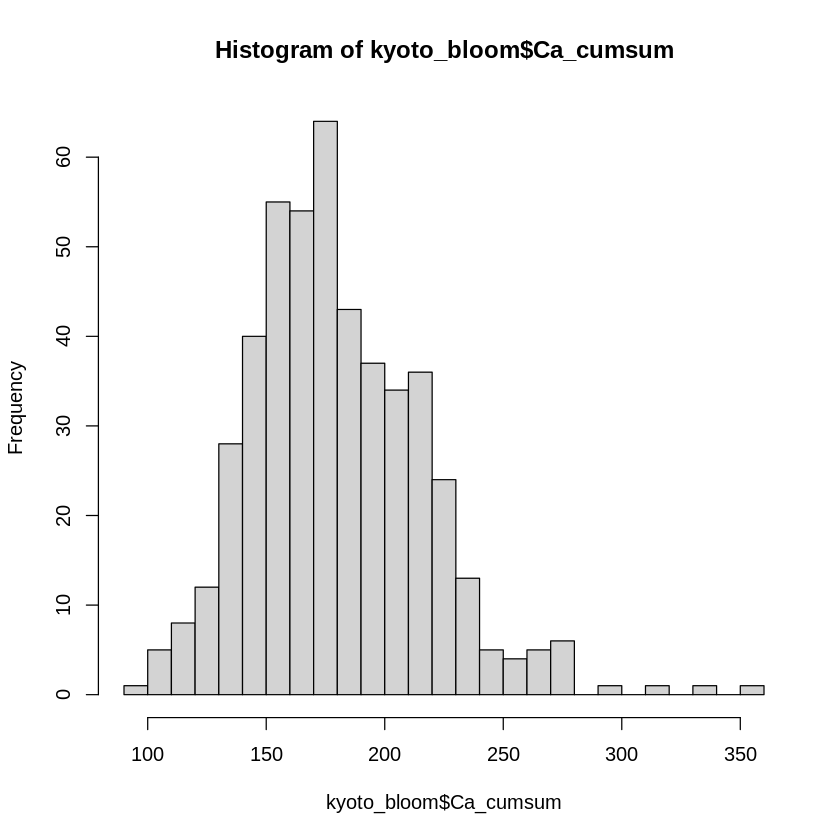

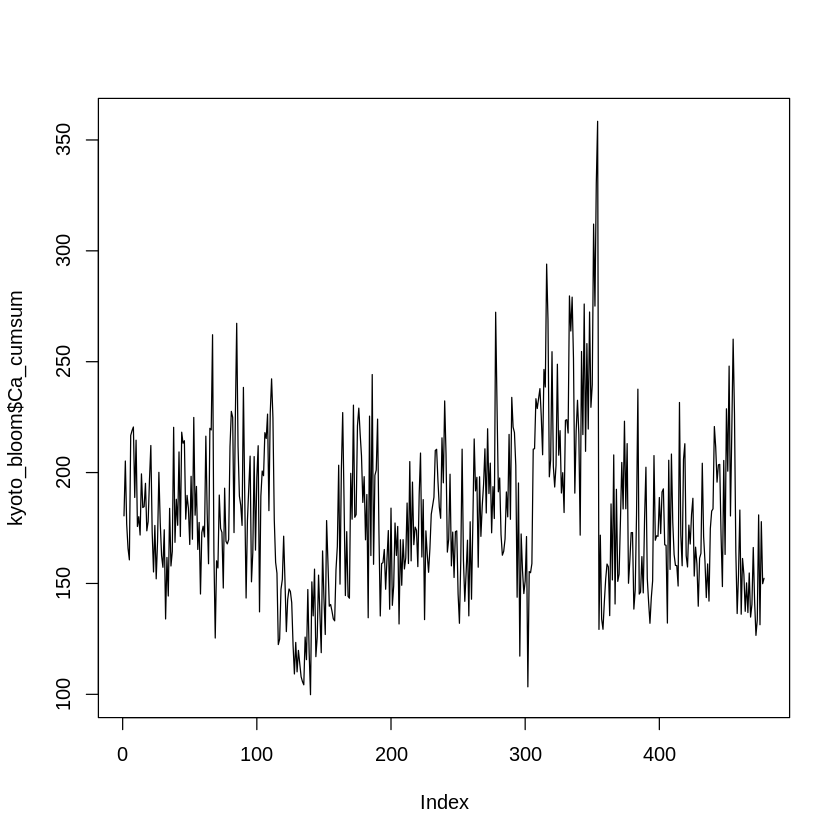

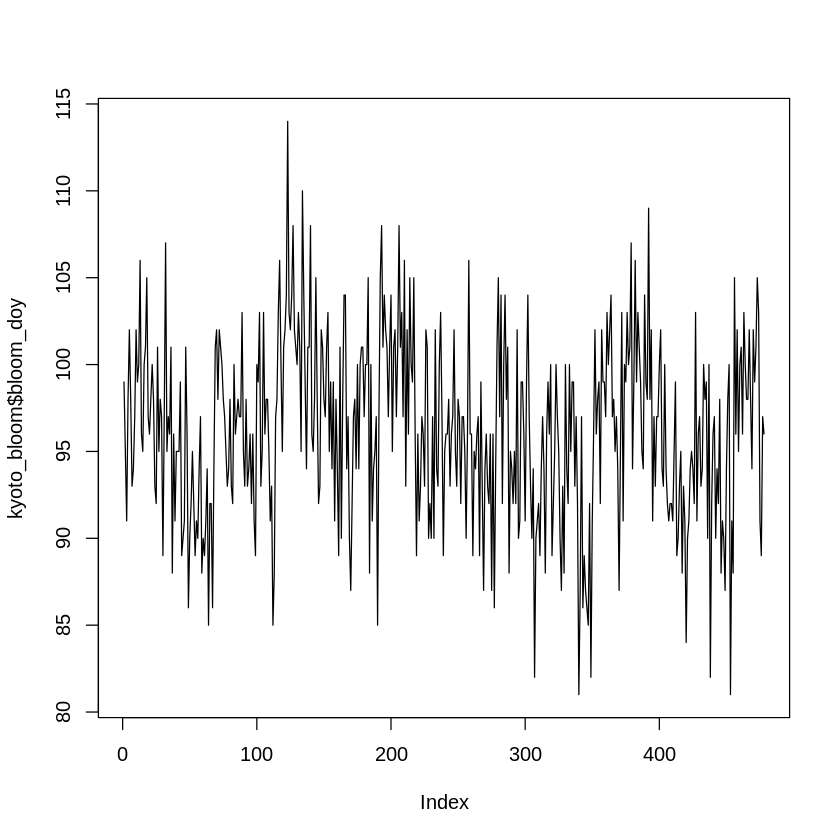

In [30]:
# kyoto_bloom_idx <- (kyoto_complete2$is_bloom == 1) & (kyoto_complete2$year > 1980)
kyoto_bloom_idx <- (kyoto_complete2$is_bloom == 1)
kyoto_bloom <- kyoto_complete2[kyoto_bloom_idx, ] %>%
    mutate(tmean = (tmax + tmin)/2) 
kyoto_bloom$idx <- seq_len(nrow(kyoto_bloom))
# dim(kyoto_bloom)
# head(kyoto_bloom)

hist(kyoto_bloom$Ca_cumsum, breaks = 30)
plot(kyoto_bloom$Ca_cumsum, type = "l")
plot(kyoto_bloom$bloom_doy, type = "l")

In [31]:
kyoto_complete2[(kyoto_complete2$Ca_cumsum > 300) & (kyoto_complete2$is_bloom), ]
kyoto_out <- kyoto_complete2 %>% filter((Ca_cumsum < 300))
write.csv(kyoto_out, "../outputs/A_outputs/A41_gdd_kyoto.csv", row.names = FALSE)

,name,date,id,tmax,tmin,prcp,year,month,day,row_num,⋯,daily_Ca,Cd_cumsum,Ca_cumsum,diff_Ca_Cd,diff_Ca_Cd_cumsum,lat,long,alt,bloom_doy,is_bloom
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
46366,SHIZUOKA,2016-04-05,JA000047656,17.8,11.8,0.5,2016,4,5,23503,⋯,7.80,-185.7460,312.05,7.80,1022.904,34.97611,138.4039,14.1,96,1
46550,SHIZUOKA,2019-04-06,JA000047656,23.5,15.8,0.0,2019,4,6,24599,⋯,12.65,-196.1693,330.35,12.65,1018.081,34.97611,138.4039,14.1,96,1
46612,SHIZUOKA,2020-04-07,JA000047656,17.6,7.4,0.0,2020,4,7,24966,⋯,5.50,-150.4878,358.40,5.50,1190.612,34.97611,138.4039,14.1,98,1


Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse




,Est.,St.Err.,t value,CI(95%).l,CI(95%).u
slope1,0.35495,0.068498,5.1818,0.22069,0.48920
slope2,-0.35382,0.042709,-8.2846,-0.43753,-0.27012


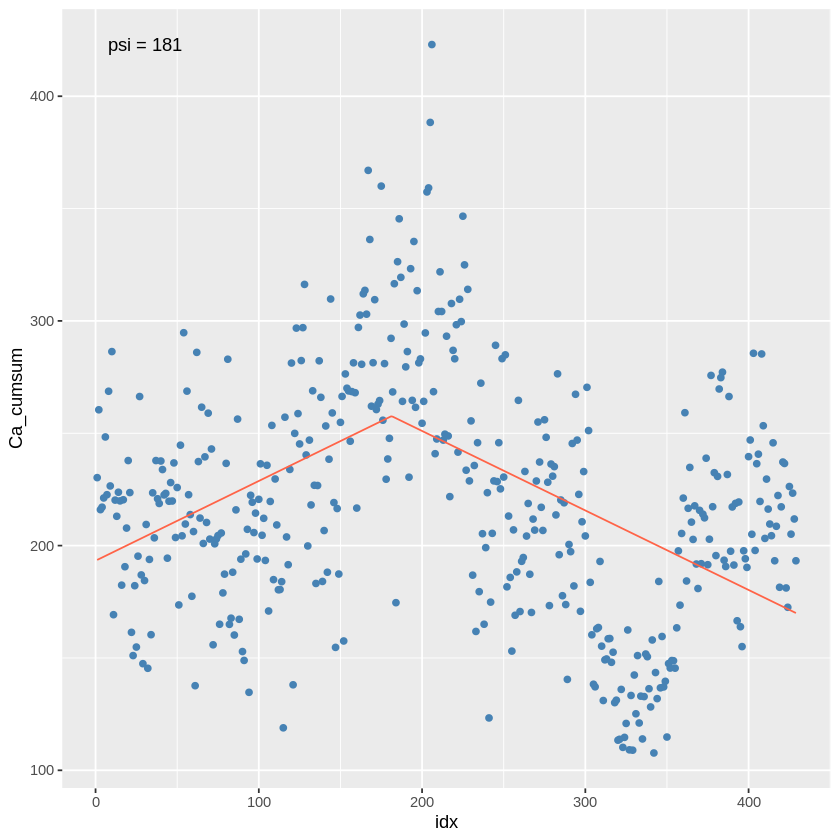

In [12]:
# perform segmented regression to find the break point.
library(segmented)
kyoto_glm <- glm(formula = Ca_cumsum ~ idx, data = kyoto_bloom, family = gaussian)
# summary(kyoto_glm)
kyoto_seg <- segmented::segmented(kyoto_glm, seg.Z = ~idx)

slope(kyoto_seg)
psi <- round(kyoto_seg$psi[, "Est."])

kyoto_fitted <- fitted(kyoto_seg)
kyoto_model <- data.frame(idx = kyoto_bloom$idx, Ca_cumsum = kyoto_fitted)

p <- ggplot(data = kyoto_bloom, aes(x = idx, y = Ca_cumsum))
p <- p + geom_point(color = "steelblue")
p <- p + geom_line(data = kyoto_model, aes(x = idx, y = Ca_cumsum), colour = "tomato")
p <- p + annotate("text", x = 30, y = max(kyoto_bloom$Ca_cumsum), label = paste0("psi = ", psi))
p